In [111]:
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import numpy as np

BASE_DIR = "/Users/helvetica/SignalProcessing/data/mc"

p_in = "in.wav"
p_out = "out.wav"
p_in_snapshot = "snapshot_in.wav"
p_out_snapshot = "snapshot_out.wav"

In [112]:
piston_in, sr = librosa.load(os.path.join(BASE_DIR, p_in))
piston_out, sr = librosa.load(os.path.join(BASE_DIR, p_out))
piston_in_snap, sr = librosa.load(os.path.join(BASE_DIR, p_in_snapshot))
piston_out_snap, sr = librosa.load(os.path.join(BASE_DIR, p_out_snapshot))

In [113]:
piston_out.shape, piston_out_snap.shape

((12171,), (9060,))

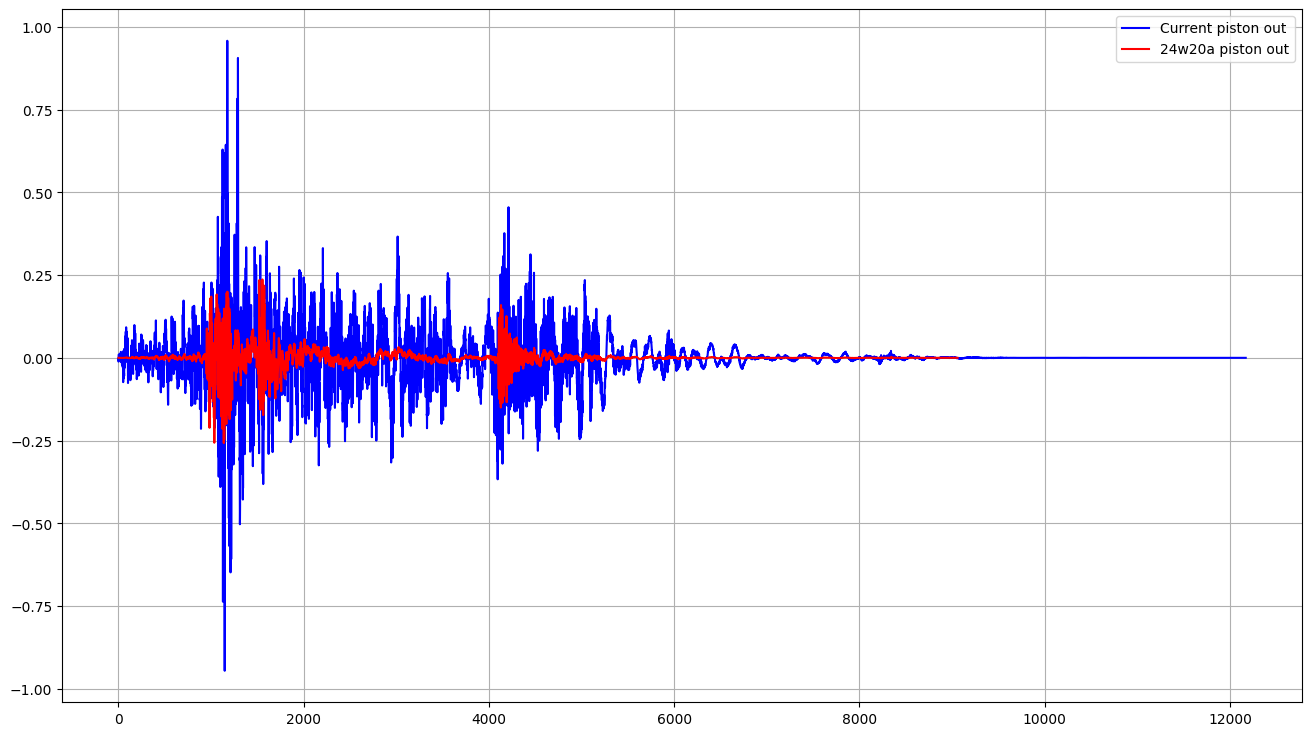

In [114]:
plt.figure(figsize=(16,9))
plt.plot(piston_out, color='b', label='Current piston out')
plt.plot(piston_out_snap, color='r', label='24w20a piston out')
plt.grid()
plt.legend()
plt.show()


0.0013230343 1.1723955e-13


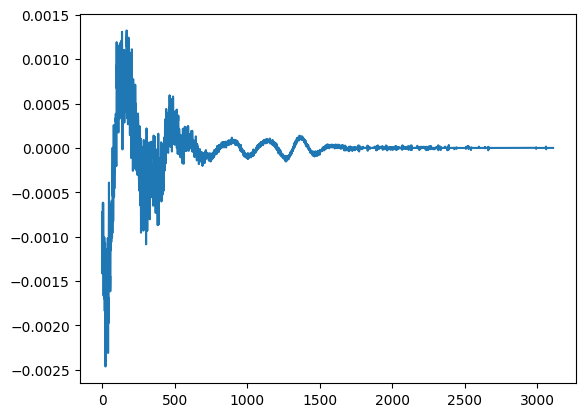

In [115]:
plt.plot(piston_out[9061:])
print(np.max(piston_out[9061:]), np.median(piston_out[9061:]))

Small enough values in the release of the sound to safely discard.

In [116]:
piston_out = piston_out[:9060]
len(piston_out) == len(piston_out_snap)

True

In [117]:
piston_out_fft, piston_out_snap_fft = np.fft.fft(piston_out), np.fft.fft(piston_out_snap)

In [118]:
piston_out_fft[0]

(-2.7551382838573772+0j)

In [119]:
magnitude_spectrum_old = np.abs(piston_out_fft)
magnitude_spectrum_new = np.abs(piston_out_snap_fft)

We don't care that much about phase, we care more about how much a freq is present, so magnitude is more informative.

We discard the phase and move from fourier coefficient to magnitude spectrum by taking the abs value of the fourier coefficient:

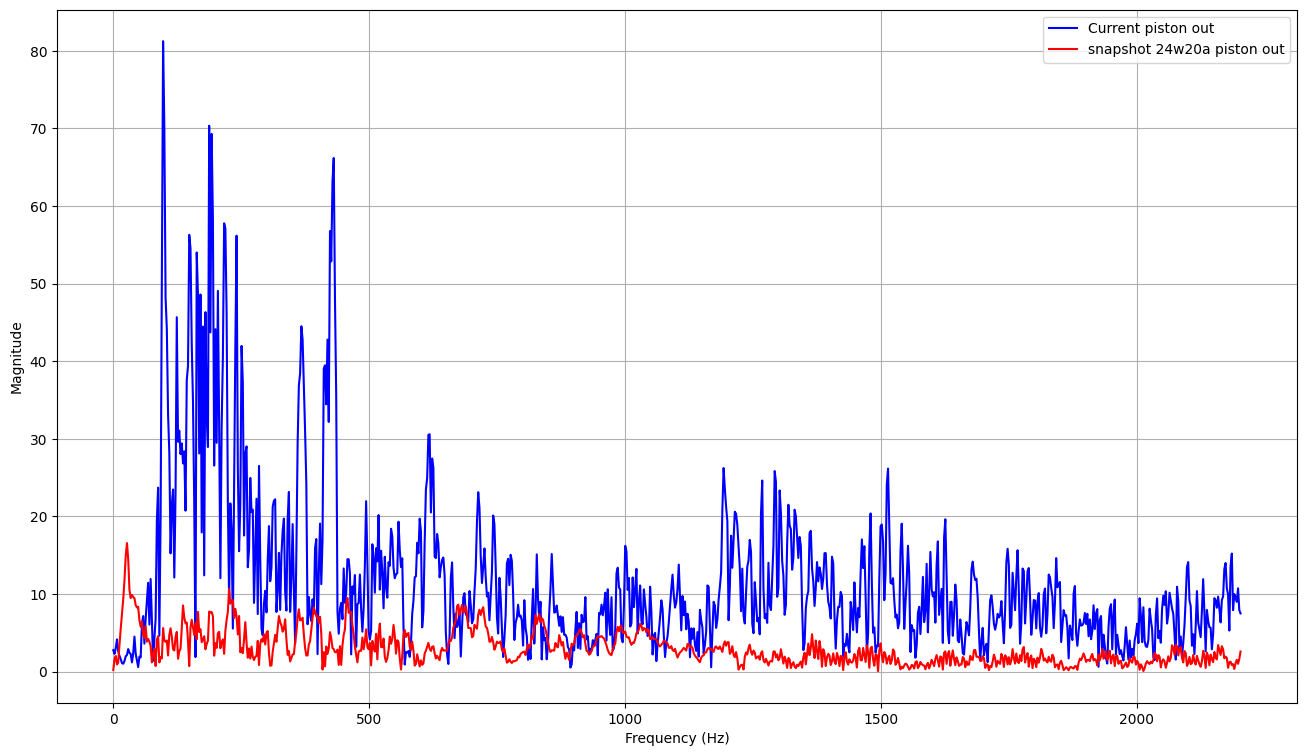

In [120]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=1, color='b'):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)

    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    n_freq_bins = int(len(frequency) * f_ratio)

    plt.plot(frequency[:n_freq_bins], magnitude_spectrum[:n_freq_bins], label=title, color=color)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()

plt.figure(figsize=(16,9))
plt.grid()
plot_magnitude_spectrum(piston_out, "Current piston out", sr, f_ratio=0.1)
plot_magnitude_spectrum(piston_out_snap, "snapshot 24w20a piston out", sr, f_ratio=0.1, color='r')
plt.show()

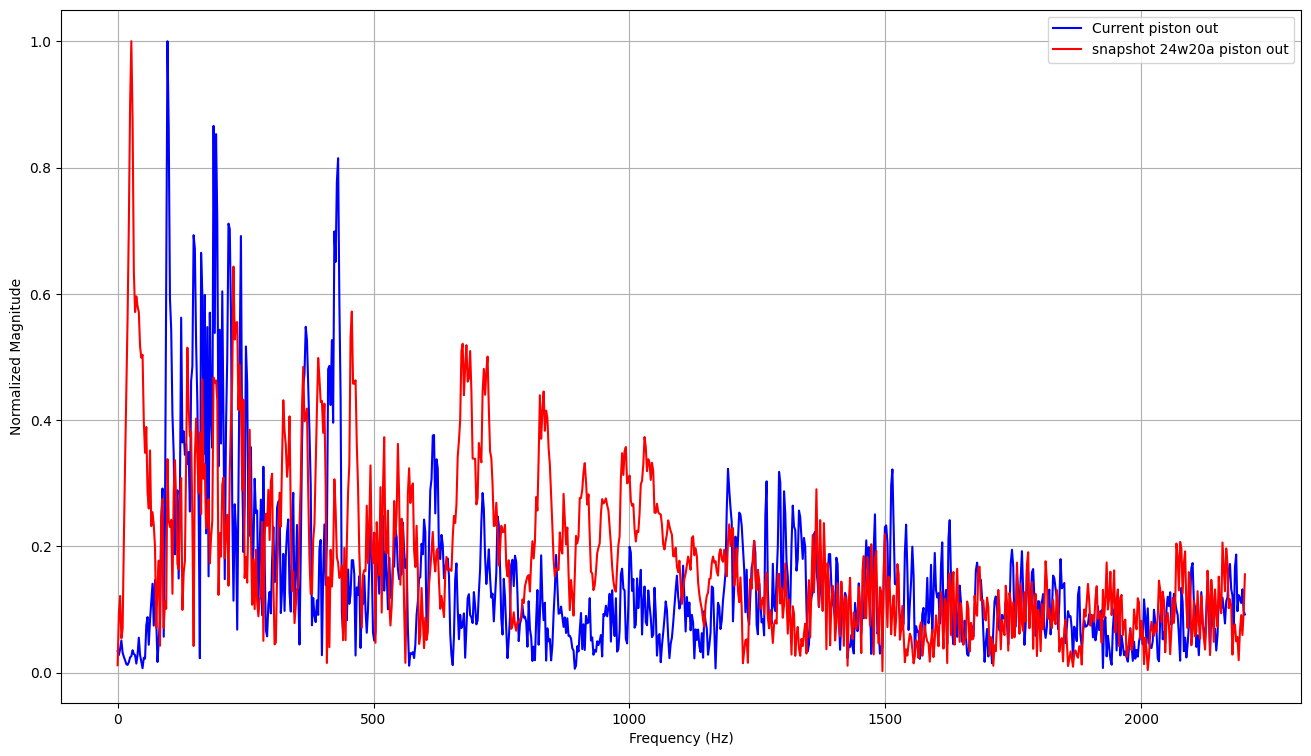

In [121]:
def plot_magnitude_spectrum(signal, title, sr, f_ratio=1, color='b'):
    ft = np.fft.fft(signal)
    magnitude_spectrum = np.abs(ft)

    magnitude_spectrum /= np.max(magnitude_spectrum)

    frequency = np.linspace(0, sr, len(magnitude_spectrum))
    n_freq_bins = int(len(frequency) * f_ratio)

    plt.plot(frequency[:n_freq_bins], magnitude_spectrum[:n_freq_bins], label=title, color=color)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized Magnitude")
    plt.legend()

plt.figure(figsize=(16,9))
plt.grid()
plot_magnitude_spectrum(piston_out, "Current piston out", sr, f_ratio=0.1)
plot_magnitude_spectrum(piston_out_snap, "snapshot 24w20a piston out", sr, f_ratio=0.1, color='r')
plt.show()


In [122]:
def rms(signal, frame_length, hop_length):
    rms = []

    for i in range(0, len(signal), hop_length):
        rms_current_frame = np.sqrt(np.sum(signal[i:i+frame_length]**2) / frame_length)
        rms.append(rms_current_frame)
    
    return np.array(rms)

FRAME_LENGTH = 1024
HOP_LENGTH = 512

rms_old = rms(piston_out, FRAME_LENGTH, HOP_LENGTH) 
rms_new = rms(piston_out_snap, FRAME_LENGTH, HOP_LENGTH) 

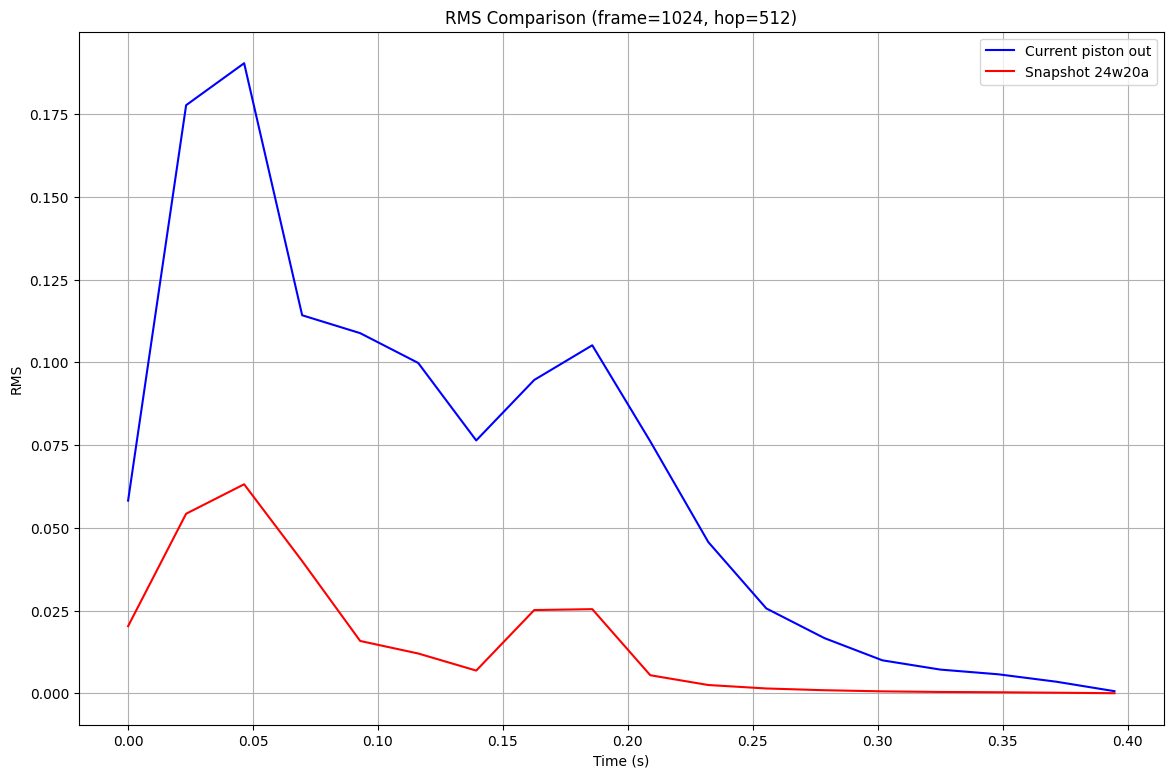

In [123]:
plt.figure(figsize=(14, 9))

frames = range(0, rms_old.size)
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

plt.plot(t, rms_old, label='Current piston out', color='b')
plt.plot(t, rms_new, label='Snapshot 24w20a', color='r')

plt.xlabel('Time (s)')
plt.ylabel('RMS')
plt.title('RMS Comparison (frame=1024, hop=512)')
plt.legend()
plt.grid()
plt.show()

In [124]:
def calculate_rms(audio):
    return librosa.feature.rms(y=audio)[0]

def compare_rms(audio1, audio2):
    rms1 = calculate_rms(audio1)
    rms2 = calculate_rms(audio2)
    return rms1, rms2

rms1, rms2 = compare_rms(piston_out, piston_out_snap)

print("Maximum RMS amplitude in the old piston sound:", np.max(rms1))
print("Maximum RMS amplitude in the 24w20a snapshot :", np.max(rms2))

Maximum RMS amplitude in the old piston sound: 0.15505832
Maximum RMS amplitude in the 24w20a snapshot : 0.047637407


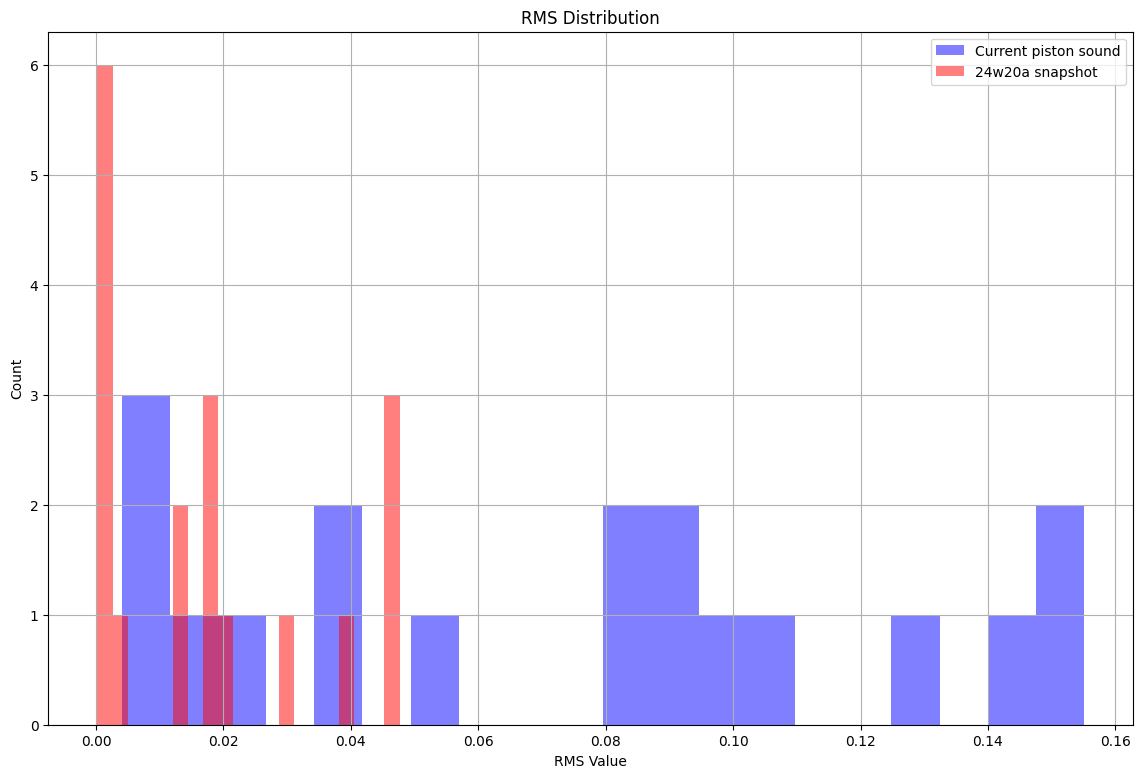

Mean RMS of current piston (out) : 0.07288974
Mean RMS of 24w20a  piston (out) : 0.017676445 

STD RMS of current piston (out)  : 0.05034394
STD RMS of 24w20a  piston (out)  : 0.016788138 

Median RMS old: 0.08348054
Median RMS new: 0.01619861

Mean RMS Difference: 312.355 %


In [125]:
mean_rms1 = np.mean(rms1)
mean_rms2 = np.mean(rms2)
std_rms1 = np.std(rms1)
std_rms2 = np.std(rms2)
median_rms1 = np.median(rms1)
median_rms2 = np.median(rms2)

plt.figure(figsize=(14, 9))
plt.hist(rms1, bins=20, color='b', alpha=0.5, label='Current piston sound')
plt.hist(rms2, bins=20, color='r', alpha=0.5, label='24w20a snapshot')
plt.legend()
plt.xlabel('RMS Value')
plt.ylabel('Count')
plt.title('RMS Distribution')
plt.grid()
plt.show()

print("Mean RMS of current piston (out) :", mean_rms1)
print("Mean RMS of 24w20a  piston (out) :", mean_rms2, "\n")
print("STD RMS of current piston (out)  :", std_rms1)
print("STD RMS of 24w20a  piston (out)  :", std_rms2, "\n")
print("Median RMS old:", median_rms1)
print("Median RMS new:", median_rms2)

mean_diff_percentage = ((mean_rms1 - mean_rms2) / mean_rms2) * 100
print(f"\nMean RMS Difference: {mean_diff_percentage:.3f} %")


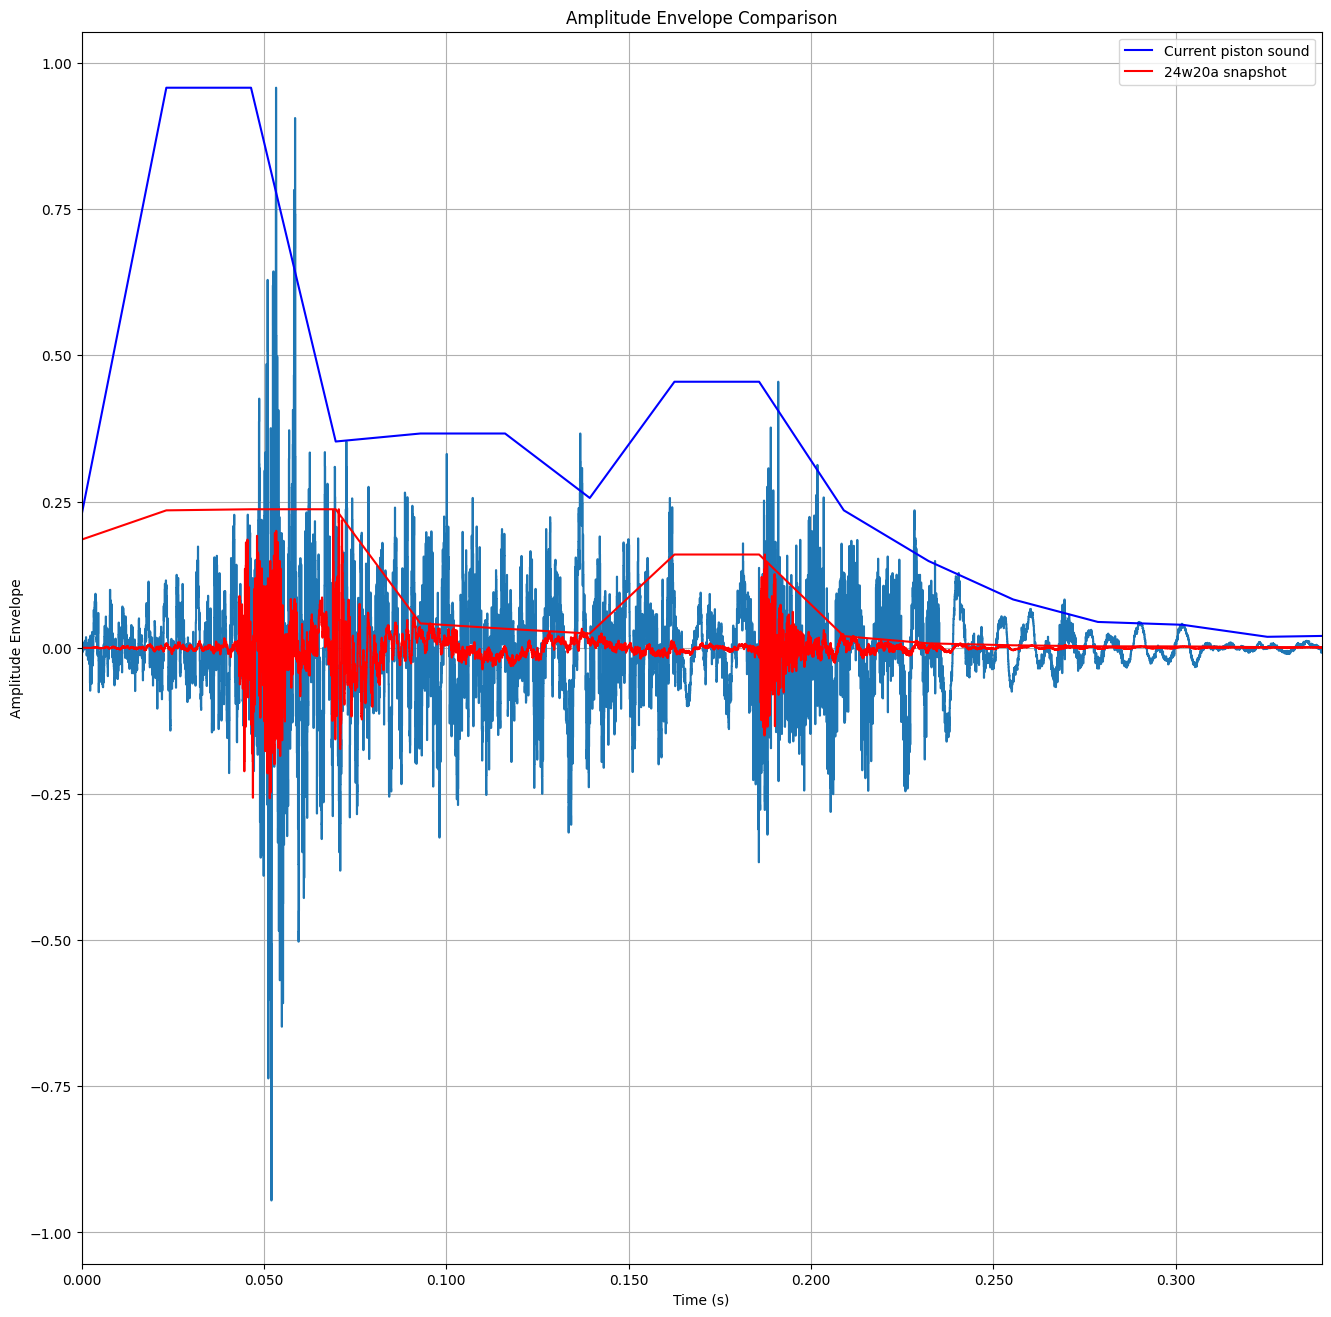

In [126]:
FRAME = 1024
HOP = 512

def amplitude_envelope(signal, frame_size, hop_length):
    return np.array([max(signal[i:i+frame_size]) for i in range(0, signal.size, hop_length)])

ae_old = amplitude_envelope(piston_out, FRAME, HOP)
ae_new = amplitude_envelope(piston_out_snap, FRAME, HOP)

frames = range(0, ae_old.size)
t = librosa.frames_to_time(frames, hop_length=HOP)

plt.figure(figsize=(16, 16))
plt.xlim(0, 0.340)
librosa.display.waveshow(piston_out, sr=sr)
librosa.display.waveshow(piston_out_snap, sr=sr, color='r')
plt.plot(t, ae_old, color='b', label='Current piston sound')
plt.plot(t, ae_new, color='r', label='24w20a snapshot')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude Envelope')
plt.title('Amplitude Envelope Comparison')
plt.legend()
plt.grid()
plt.show()


In [127]:
Y_out_new = librosa.stft(piston_out_snap, n_fft=FRAME, hop_length=HOP)
Y_out_old = librosa.stft(piston_out, n_fft=FRAME, hop_length=HOP)

Y_out_new = np.abs(Y_out_new) ** 2
Y_out_old = np.abs(Y_out_old) ** 2

In [128]:
def plot_spectrogram(Y, sr, hop_length, y_axis="log", title=""):
    plt.figure(figsize=(12,8))
    plt.title(title)
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)

    plt.colorbar(format="%+2.f")

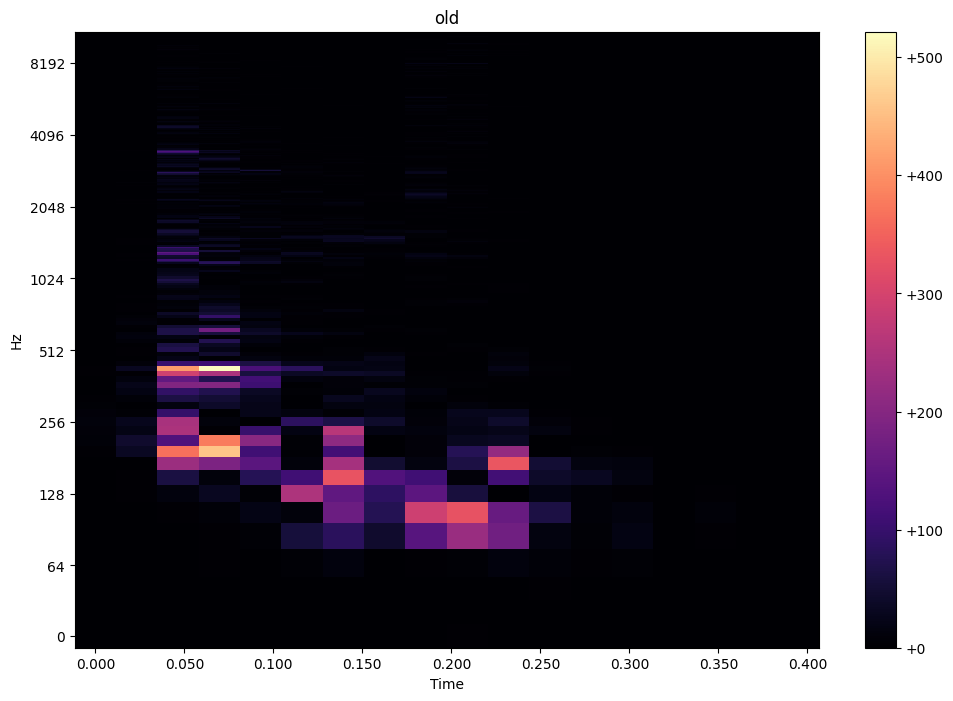

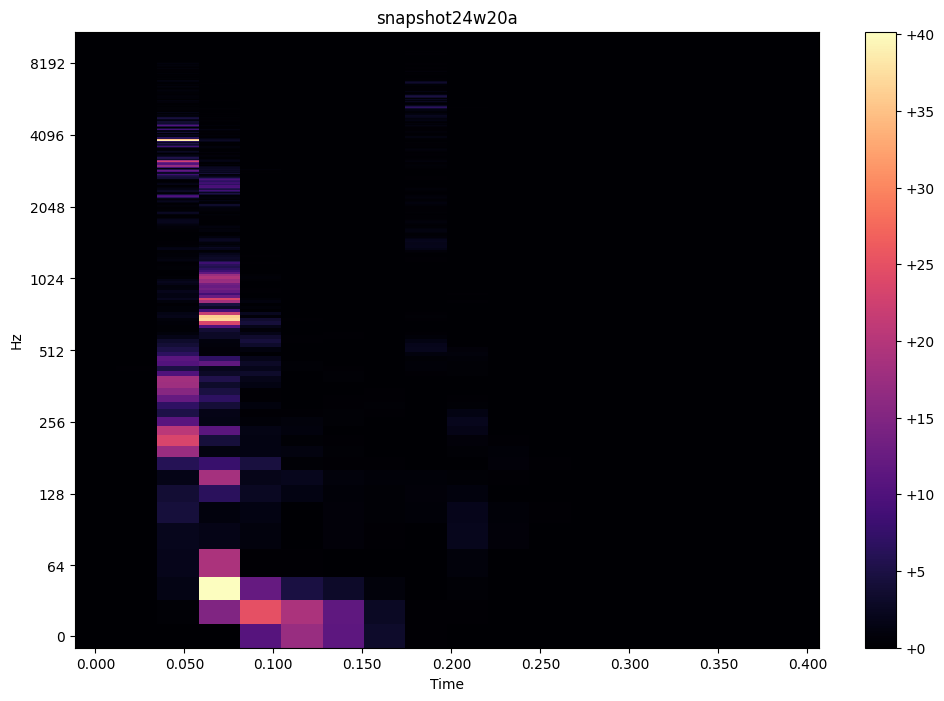

In [129]:
plot_spectrogram(Y_out_old, sr, HOP, title="old")
plot_spectrogram(Y_out_new, sr, HOP, title="snapshot24w20a")

In [130]:
mel_spectrogram = librosa.feature.melspectrogram(y=piston_out, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=10)

old_log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

mel_spectrogram = librosa.feature.melspectrogram(y=piston_out_snap, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
new_log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)


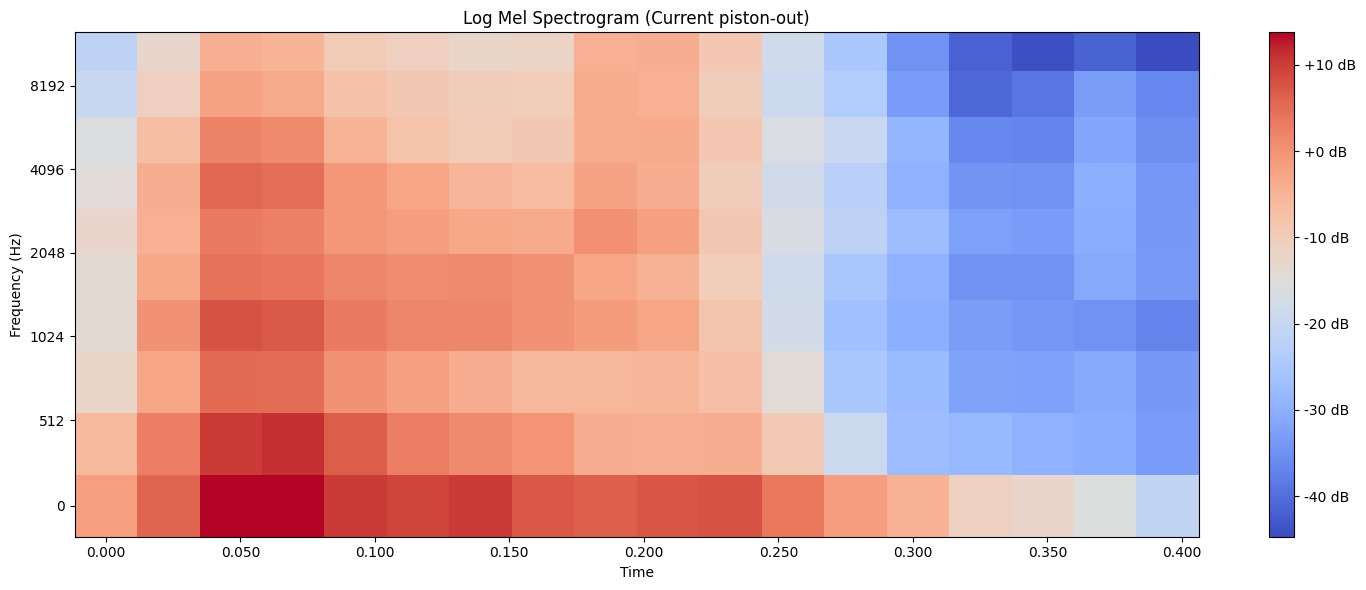

In [131]:
def plot_mel_spectrogram(mel_spectrogram, sr, title=None):
    plt.figure(figsize=(15, 6))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title if title else 'Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()


plot_mel_spectrogram(old_log_mel_spectrogram, sr, title='Log Mel Spectrogram (Current piston-out)')


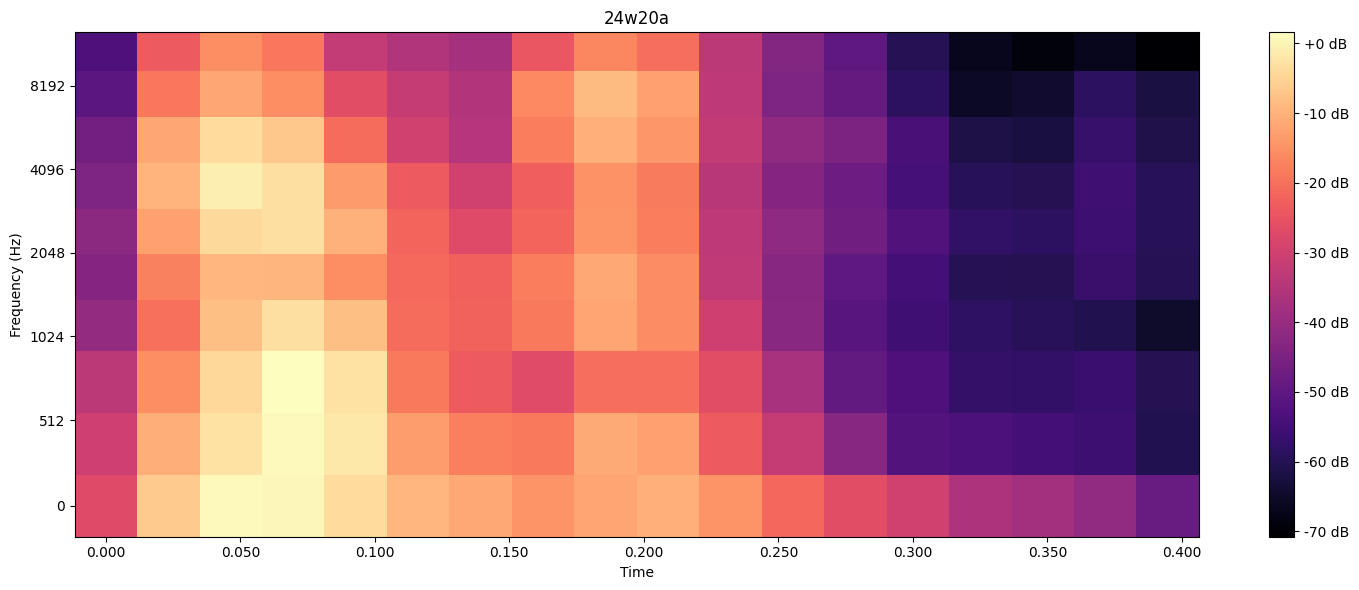

In [132]:
plot_mel_spectrogram(new_log_mel_spectrogram, sr, title='24w20a')


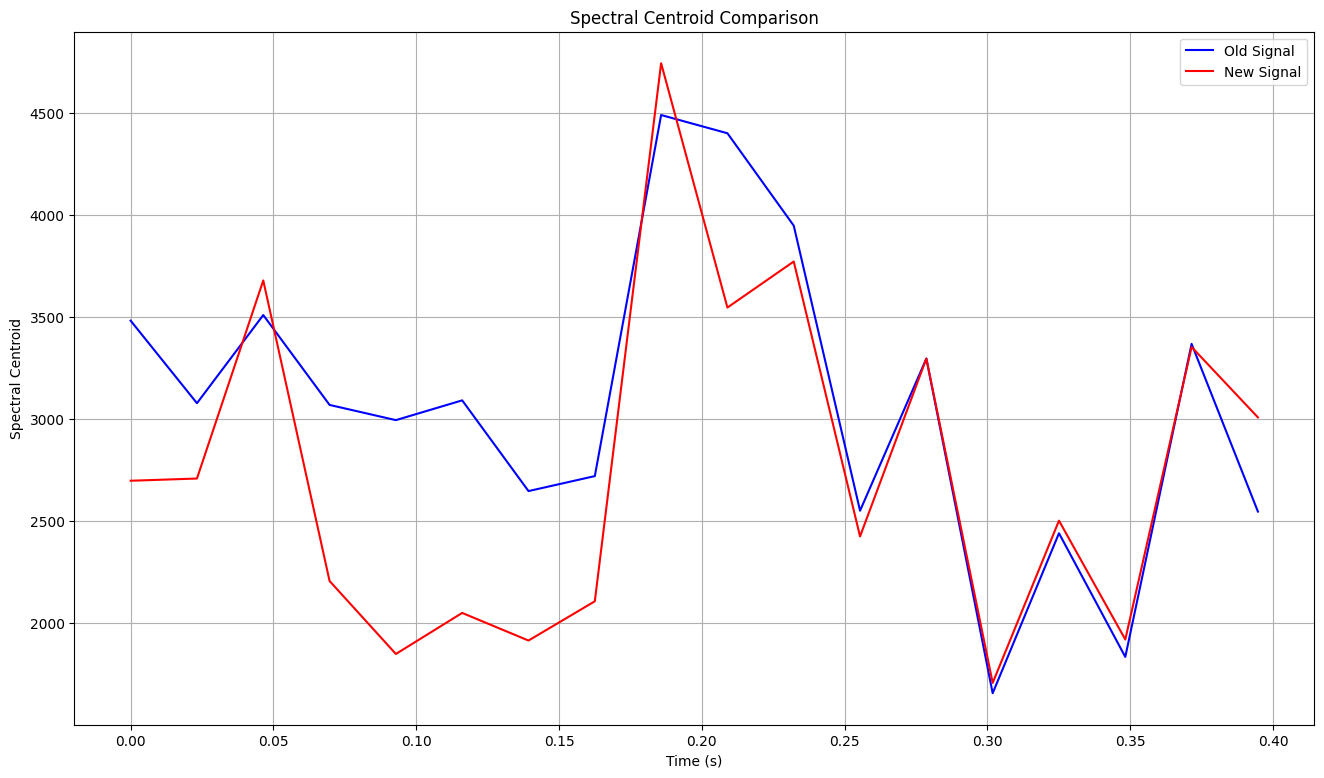

In [133]:
import matplotlib.pyplot as plt
import librosa

FRAME_SIZE = 1024
HOP_LENGTH = 512

sc_old = librosa.feature.spectral_centroid(y=piston_out, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
sc_new = librosa.feature.spectral_centroid(y=piston_out_snap, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

frames = range(len(sc_old))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(16,9))
plt.plot(t, sc_old, color='b', label='Old Signal')
plt.plot(t, sc_new, color='r', label='New Signal')
plt.xlabel('Time (s)')
plt.ylabel('Spectral Centroid')
plt.title('Spectral Centroid Comparison')
plt.legend()
plt.grid()
plt.show()


In [134]:
import pandas as pd

def load_ogg_files(directory, exclude_dirs=None):
    if exclude_dirs is None:
        exclude_dirs = []

    ogg_files = []
    
    for root, dirs, files in os.walk(directory):
        dirs[:] = [d for d in dirs if os.path.join(root, d) not in exclude_dirs]

        for file in files:
            if file.endswith('.ogg'):
                file_path = os.path.join(root, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    if len(y) < 2048:
                        pad_length = 2048 - len(y)
                        y = np.pad(y, (0, pad_length), mode='constant')
                        print(f"Signal for {file_path} padded with {pad_length} zeros.")
                    ogg_files.append((file_path, y, sr))
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
    
    return ogg_files

def compute_rms(y):
    rms = librosa.feature.rms(y=y)[0]
    return float(np.mean(rms))

def compute_spectral_centroid(y, sr):
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    return float(np.mean(spectral_centroid))

def create_dataframe(directory, exclude_dirs=None):
    ogg_files = load_ogg_files(directory, exclude_dirs)
    data = []

    for file_path, y, sr in ogg_files:
        dir_name = os.path.basename(os.path.dirname(file_path))
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        new_name = f"{dir_name}-{file_name}"
        rms_value = compute_rms(y)
        spectral_centroid_value = compute_spectral_centroid(y, sr)
        data.append((new_name, rms_value, spectral_centroid_value))
    
    df = pd.DataFrame(data, columns=['File Name', 'RMS', 'Spectral Centroid'])
    return df

directory = '/Users/helvetica/MC_Sounds/sounds'
exclude_dirs = ['/Users/helvetica/MC_Sounds/sounds/music', '/Users/helvetica/MC_Sounds/sounds/ambient']

df = create_dataframe(directory, exclude_dirs)
df.head()


Signal for /Users/helvetica/MC_Sounds/sounds/mob/parrot/step1.ogg padded with 352 zeros.
Signal for /Users/helvetica/MC_Sounds/sounds/mob/chicken/step1.ogg padded with 325 zeros.


,File Name,RMS,Spectral Centroid
0,stonecutter-cut2,0.036405,2590.671092
1,stonecutter-cut1,0.041283,2305.700301
2,toast-in,0.001721,4141.084982
3,toast-challenge_complete,0.069067,1785.935281
4,toast-out,0.002083,3673.261597


In [135]:
df.sort_values("RMS", ascending=False)

,File Name,RMS,Spectral Centroid
1452,wolf-howl2,0.382393,1263.164290
1604,bat-idle3,0.369677,8769.310128
1794,horse-hit4,0.345256,4525.842542
1608,bat-idle4,0.337106,9662.458252
1798,horse-hit1,0.322912,3231.575535
...,...,...,...
3361,pointed_dripstone-drip_water7,0.000828,6617.672706
3366,pointed_dripstone-drip_water12,0.000810,9563.073499
2541,candle-ambient2,0.000547,7317.413766
2542,candle-ambient3,0.000522,5554.859818


In [136]:
def add_items_to_dataframe(df, new_paths):
    new_data = []

    for path in new_paths:
        if os.path.isfile(path) and path.lower().endswith('.ogg'):
            try:
                y, sr = librosa.load(path, sr=None)
                if len(y) < 2048:
                    pad_length = 2048 - len(y)
                    y = np.pad(y, (0, pad_length), mode='constant')
                    print(f"Warning: Input signal padded with {pad_length} zeros.")

                rms_value = float(np.mean(librosa.feature.rms(y=y)[0]))
                spectral_centroid_value = float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0]))

                dir_name = os.path.basename(os.path.dirname(path))
                file_name = os.path.splitext(os.path.basename(path))[0]
                new_name = f"{dir_name}-{file_name}"

                new_data.append((new_name, rms_value, spectral_centroid_value))
            except Exception as e:
                print(f"Error processing {path}: {e}")
        else:
            print(f"Error: {path} is not a valid .ogg file.")

    if new_data:
        new_df = pd.DataFrame(new_data, columns=['File Name', 'RMS', 'Spectral Centroid'])
        df = pd.concat([df, new_df], ignore_index=True)
        return df
    else:
        return df


new_paths = ['/Users/helvetica/SignalProcessing/data/mc/piston/in.ogg', '/Users/helvetica/SignalProcessing/data/mc/piston/out.ogg']
df = add_items_to_dataframe(df, new_paths)

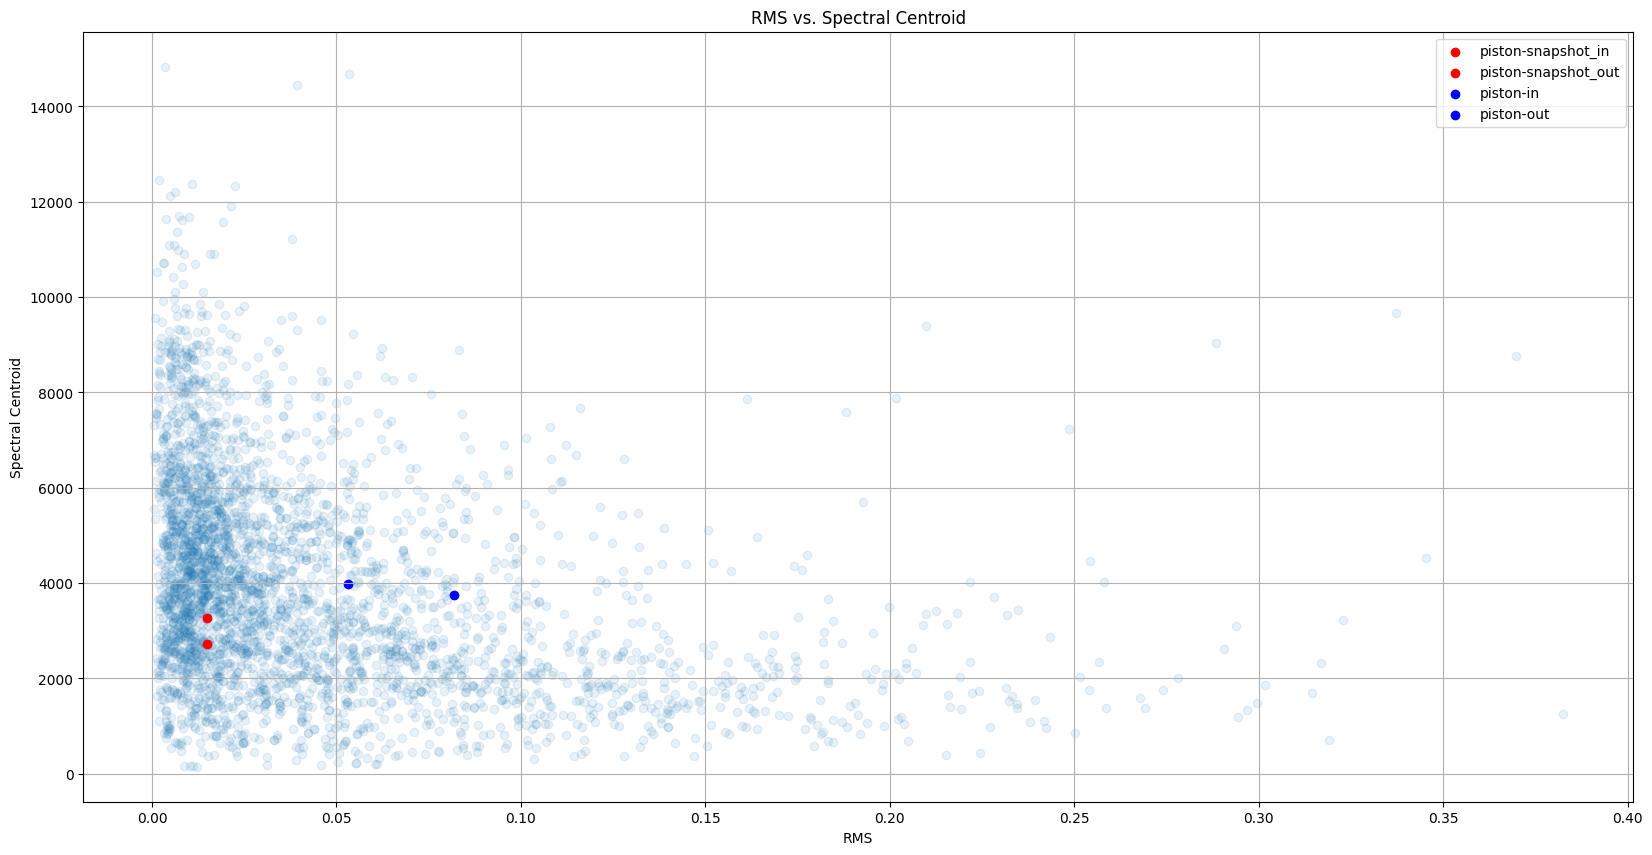

Difference in Mean RMS:
piston-snapshot_in - piston-in: -0.06677325069904327
piston-snapshot_out - piston-out: -0.03822379186749458
piston-snapshot_in - all items: -0.028990836115193423
piston-snapshot_out - all items: -0.028990281046938952

Difference in Mean Spectral Centroid:
piston-snapshot_in - piston-in: -1034.006571322423
piston-snapshot_out - piston-out: -711.6470610773786
piston-snapshot_in - all items: -1206.4517179726677
piston-snapshot_out - all items: -667.5195435474843


In [137]:
def plot_scatter_with_highlight(df, highlight_objects=None, highlight_color='red'):
    plt.figure(figsize=(20, 10))
    plt.grid(True)
    plt.scatter(df['RMS'], df['Spectral Centroid'], alpha=0.1)
    
    if highlight_objects:
        color_index = 0
        color_map = {} 
        for obj_name in highlight_objects:
            obj_data = df[df['File Name'].str.contains(obj_name)]
            if not obj_data.empty:
                if obj_name not in color_map:
                    color_map[obj_name] = highlight_color[color_index]
                    color_index += 1
                plt.scatter(obj_data['RMS'], obj_data['Spectral Centroid'], color=color_map[obj_name], label=obj_name)
    
    plt.xlabel('RMS')
    plt.ylabel('Spectral Centroid')
    plt.title('RMS vs. Spectral Centroid')
    plt.legend()
    plt.show()

    piston_snapshot_in_mean_rms = df[df['File Name'].str.contains('piston-snapshot_in', case=False)]['RMS'].mean()
    piston_snapshot_out_mean_rms = df[df['File Name'].str.contains('piston-snapshot_out', case=False)]['RMS'].mean()
    piston_in_mean_rms = df[df['File Name'].str.contains('piston-in', case=False)]['RMS'].mean()
    piston_out_mean_rms = df[df['File Name'].str.contains('piston-out', case=False)]['RMS'].mean()

    piston_snapshot_in_mean_centroid = df[df['File Name'].str.contains('piston-snapshot_in', case=False)]['Spectral Centroid'].mean()
    piston_snapshot_out_mean_centroid = df[df['File Name'].str.contains('piston-snapshot_out', case=False)]['Spectral Centroid'].mean()
    piston_in_mean_centroid = df[df['File Name'].str.contains('piston-in', case=False)]['Spectral Centroid'].mean()
    piston_out_mean_centroid = df[df['File Name'].str.contains('piston-out', case=False)]['Spectral Centroid'].mean()

    all_mean_rms = df['RMS'].mean()
    all_mean_centroid = df['Spectral Centroid'].mean()

    print("Difference in Mean RMS:")
    print("piston-snapshot_in - piston-in:", piston_snapshot_in_mean_rms - piston_in_mean_rms)
    print("piston-snapshot_out - piston-out:", piston_snapshot_out_mean_rms - piston_out_mean_rms)
    print("piston-snapshot_in - all items:", piston_snapshot_in_mean_rms - all_mean_rms)
    print("piston-snapshot_out - all items:", piston_snapshot_out_mean_rms - all_mean_rms)
    
    print("\nDifference in Mean Spectral Centroid:")
    print("piston-snapshot_in - piston-in:", piston_snapshot_in_mean_centroid - piston_in_mean_centroid)
    print("piston-snapshot_out - piston-out:", piston_snapshot_out_mean_centroid - piston_out_mean_centroid)
    print("piston-snapshot_in - all items:", piston_snapshot_in_mean_centroid - all_mean_centroid)
    print("piston-snapshot_out - all items:", piston_snapshot_out_mean_centroid - all_mean_centroid)

highlight_objects = ['piston-snapshot_in', 'piston-snapshot_out', 'piston-in', 'piston-out']
highlight_color = ['r', 'r', 'b', 'b'] 

plot_scatter_with_highlight(df, highlight_objects, highlight_color)


In [138]:
import plotly.express as px

def plot_scatter_with_highlight(df, highlight_objects=None, highlight_color='red'):
    fig = px.scatter(df, x='RMS', y='Spectral Centroid', title='Scatter Plot of RMS vs. Spectral Centroid')

    fig.update_traces(marker=dict(color='white', opacity=0.3))

    if highlight_objects:
        color_index = 0
        color_map = {}
        for obj_name in highlight_objects:
            obj_data = df[df['File Name'].str.contains(obj_name)]
            if not obj_data.empty:
                if obj_name not in color_map:
                    color_map[obj_name] = highlight_color[color_index]
                    color_index += 1
                fig.add_scatter(x=obj_data['RMS'], y=obj_data['Spectral Centroid'], mode='markers', name=obj_name, hovertext=obj_data['File Name'], marker=dict(color=color_map[obj_name], opacity=0.7))

    fig.show()

highlight_objects = ['piston-snapshot_in', 'piston-snapshot_out', 'piston-in', 'piston-out']
highlight_color = ['red', 'red', 'blue', 'blue']

plot_scatter_with_highlight(df, highlight_objects, highlight_color)
